In [19]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from pycaret.classification import *
df = pd.read_csv('/kaggle/input/airlines-delay/airlines_delay.csv')
from sklearn.model_selection import cross_val_score


In [ ]:
pip install --pre pycaret

# Data Analysis

**1. **Statistical****

In [ ]:
print('Before Feature Engineering')
df.describe()
df_2 = df

# **Feature Engineering**

In [20]:
# print(df.dtypes)
#New column IsLate 
#df['IsLate'] = np.where(df['Class']==1,True,False)

col_Names = list(df.columns)



# add new column flight duration category

condition = [(df['Length']<=180),
            (df['Length']>=181) & (df['Length']<=360),
            (df['Length']>=361)]
values = ['shot_haul','medium_haul','long_haul']
df['FlightCategory'] = np.select(condition, values)

# add new column Part of the Day

condition_2 = [(df['Time']>=300) & (df['Time']<=720), # Morning
            (df['Time']>=721) & (df['Time']<=1020), # After Noon
            (df['Time']>=1021) & (df['Time']<=1260), # Evening
            (df['Time']>=1261),  # Night
            (df['Time']<300)] # Night
values_2 = ['morning','efter_noon','evening','night','night']
df['DepTimeOfDay'] = np.select(condition_2, values_2)

# add new column Part of the Day
df['ArrivalTime'] = (df['Time'] + df['Length']) 
df['ArrivalTime'] = df['ArrivalTime'].apply(lambda x : x - 1440 if x > 1440 else x)

condition_3 = [(df['ArrivalTime']>=300) & (df['ArrivalTime']<=720), # Morning
            (df['ArrivalTime']>=721) & (df['ArrivalTime']<=1020), # After Noon
            (df['ArrivalTime']>=1021) & (df['ArrivalTime']<=1260), # Evening
            (df['ArrivalTime']>=1261),  # Night
            (df['ArrivalTime']<300)] # Night
values_3 = ['morning','efter_noon','evening','night','night']
df['ArriTimeOfDay'] = np.select(condition_3, values_3)

# Departure ariport category 

DepAirportMean = df.groupby('AirportFrom')['Class'].mean()
temp = list(DepAirportMean.describe())

excellent = DepAirportMean[DepAirportMean >= temp[6]]
good = DepAirportMean[(DepAirportMean >= temp[4]) & (DepAirportMean < temp[6])]
worst = DepAirportMean[DepAirportMean < temp[4]]

df['FromAirpotCat'] = ''
df.loc[df['AirportFrom'].isin(worst.index), 'FromAirpotCat'] = 'Worst'
df.loc[df['AirportFrom'].isin(good.index), 'FromAirpotCat'] = 'Good'
df.loc[df['AirportFrom'].isin(excellent.index), 'FromAirpotCat'] = 'Excellent'


# Arrival airport category
ArrivalAirportMean = df.groupby('AirportFrom')['Class'].mean()
temp_1 = list(ArrivalAirportMean.describe())

excellent = ArrivalAirportMean[ArrivalAirportMean >= temp_1[6]]
good = ArrivalAirportMean[(ArrivalAirportMean >= temp_1[4]) & (ArrivalAirportMean < temp_1[6])]
worst = ArrivalAirportMean[ArrivalAirportMean < temp_1[4]]

df['ToAirpotCat'] = ''
df.loc[df['AirportTo'].isin(worst.index), 'ToAirpotCat'] = 'Worst'
df.loc[df['AirportTo'].isin(good.index), 'ToAirpotCat'] = 'Good'
df.loc[df['AirportTo'].isin(excellent.index), 'ToAirpotCat'] = 'Excellent'


In [21]:
df

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class,FlightCategory,DepTimeOfDay,ArrivalTime,ArriTimeOfDay,FromAirpotCat,ToAirpotCat
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0,shot_haul,night,1437.0,night,Good,Excellent
1,6948.0,360.0,146.0,OO,COS,ORD,4,0,shot_haul,morning,506.0,morning,Good,Excellent
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0,shot_haul,evening,1313.0,night,Good,Good
3,31.0,1410.0,344.0,US,OGG,PHX,6,0,medium_haul,night,314.0,morning,Worst,Excellent
4,563.0,692.0,98.0,FL,BMI,ATL,4,0,shot_haul,morning,790.0,efter_noon,Good,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539377,6973.0,530.0,72.0,OO,GEG,SEA,5,1,shot_haul,morning,602.0,morning,Excellent,Good
539378,1264.0,560.0,115.0,WN,LAS,DEN,4,1,shot_haul,morning,675.0,morning,Excellent,Excellent
539379,5209.0,827.0,74.0,EV,CAE,ATL,2,1,shot_haul,efter_noon,901.0,efter_noon,Good,Good
539380,607.0,715.0,65.0,WN,BWI,BUF,4,1,shot_haul,morning,780.0,efter_noon,Excellent,Excellent


In [22]:
print('After Feature Engineering')
df.describe()

After Feature Engineering


,Flight,Time,Length,DayOfWeek,Class,ArrivalTime
count,539382.000000,539382.000000,539382.000000,539382.000000,539382.000000,539382.000000
mean,2427.927988,802.728161,132.202104,3.929666,0.445443,899.308164
std,2067.431700,278.045546,70.117045,1.914666,0.497015,295.737750
min,1.000000,10.000000,0.000000,1.000000,0.000000,1.000000
25%,712.000000,565.000000,81.000000,2.000000,0.000000,678.000000
50%,1809.000000,795.000000,115.000000,4.000000,0.000000,903.000000
75%,3745.000000,1035.000000,162.000000,5.000000,1.000000,1136.000000
max,7814.000000,1439.000000,655.000000,7.000000,1.000000,1440.000000


# Label Encoding

In [23]:
from sklearn.preprocessing import LabelEncoder

# create an instance of LabelEncoder
le = LabelEncoder()

# encode each categorical column
for col in df.select_dtypes(include=['object']):
    df[col] = le.fit_transform(df[col])

# print the original and encoded dataframes

df.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class,FlightCategory,DepTimeOfDay,ArrivalTime,ArriTimeOfDay,FromAirpotCat,ToAirpotCat
0,2313.0,1296.0,141.0,5,16,129,1,0,2,3,1437.0,3,1,0
1,6948.0,360.0,146.0,12,65,208,4,0,2,2,506.0,2,1,0
2,1247.0,1170.0,143.0,3,35,60,3,0,2,1,1313.0,3,1,1
3,31.0,1410.0,344.0,14,203,217,6,0,1,3,314.0,2,2,0
4,563.0,692.0,98.0,8,32,16,4,0,2,2,790.0,0,1,1


In [24]:
df.nunique()

Flight            6585
Time              1131
Length             426
Airline             18
AirportFrom        293
AirportTo          293
DayOfWeek            7
Class                2
FlightCategory       3
DepTimeOfDay         4
ArrivalTime       1379
ArriTimeOfDay        4
FromAirpotCat        3
ToAirpotCat          3
dtype: int64

In [13]:
#sns.pairplot(data= df,hue='Class',palette='Dark2',diag_kind='kde')

#plt.show()

#plt.clf()

# sns.pairplot(data= df,hue='Class',palette='Dark2',diag_kind='auto', kind = 'reg')

# plt.show()

no of time delayed befor
morning afternoon evening arrival / departure categories


charts
by airport 
by morning evening


Bar plot

1. * # Data Analysis 

**Bar Plots of Categorical Columns**

In [ ]:

cat_features = ['Flight', 'Time', 'Length', 'Airline', 'AirportFrom', 'AirportTo','DayOfWeek', 'FlightCategory', 'DepTimeOfDay','ArrivalTime', 'ArriTimeOfDay', 'FromAirpotCat', 'ToAirpotCat']
fig , ax = plt.subplots(14,1,figsize = (40,40))     # set up 2 x 2 frame count plot with figsize 10 x 10
for i , subplots in zip (cat_features, ax.flatten()):
    sns.countplot(data=df,x=df[i],hue = df['Class'],ax = subplots, palette = 'BuPu')
plt.show()

In [26]:
df.tail()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class,FlightCategory,DepTimeOfDay,ArrivalTime,ArriTimeOfDay,FromAirpotCat,ToAirpotCat
539377,6973.0,530.0,72.0,12,111,252,5,1,2,2,602.0,2,0,1
539378,1264.0,560.0,115.0,15,153,79,4,1,2,2,675.0,2,0,0
539379,5209.0,827.0,74.0,6,47,16,2,1,2,0,901.0,0,1,1
539380,607.0,715.0,65.0,15,45,43,4,1,2,2,780.0,0,0,0
539381,6377.0,770.0,55.0,12,67,79,2,1,2,0,825.0,0,1,0


In [27]:
df.corr()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class,FlightCategory,DepTimeOfDay,ArrivalTime,ArriTimeOfDay,FromAirpotCat,ToAirpotCat
Flight,1.000000,-0.005750,-0.341481,0.095285,-0.021801,-0.022072,0.000416,-0.046174,0.276613,-0.017047,-0.003831,-0.029971,0.073094,0.070833
Time,-0.005750,1.000000,-0.020610,0.004381,-0.031553,0.030602,0.001272,0.150457,0.013704,-0.367532,0.727225,0.176402,-0.033277,0.042512
Length,-0.341481,-0.020610,1.000000,-0.207061,0.049697,0.086980,0.013398,0.040488,-0.833838,0.045487,-0.017875,0.054710,-0.057350,-0.111060
Airline,0.095285,0.004381,-0.207061,1.000000,0.098237,0.098791,-0.007258,0.066936,0.171187,-0.013389,0.018454,-0.028575,-0.189727,-0.190479
AirportFrom,-0.021801,-0.031553,0.049697,0.098237,1.000000,0.015137,0.003732,0.018458,-0.044436,0.007718,-0.021395,-0.013791,-0.163360,-0.115517
AirportTo,-0.022072,0.030602,0.086980,0.098791,0.015137,1.000000,0.003847,0.047988,-0.101632,0.013375,0.019232,0.025196,-0.116475,-0.163160
DayOfWeek,0.000416,0.001272,0.013398,-0.007258,0.003732,0.003847,1.000000,-0.026198,-0.011123,-0.005604,-0.000387,-0.014253,0.002709,0.002683
Class,-0.046174,0.150457,0.040488,0.066936,0.018458,0.047988,-0.026198,1.000000,-0.044052,-0.107764,0.138042,-0.036755,-0.143130,-0.087985
FlightCategory,0.276613,0.013704,-0.833838,0.171187,-0.044436,-0.101632,-0.011123,-0.044052,1.000000,-0.050572,0.035606,-0.045785,0.048415,0.090551
DepTimeOfDay,-0.017047,-0.367532,0.045487,-0.013389,0.007718,0.013375,-0.005604,-0.107764,-0.050572,1.000000,-0.474253,0.417112,-0.014017,-0.004472


1. # **2. Correlation **

* Convert Categorical values to numerical values for correlation
* Correlation with targer variable 

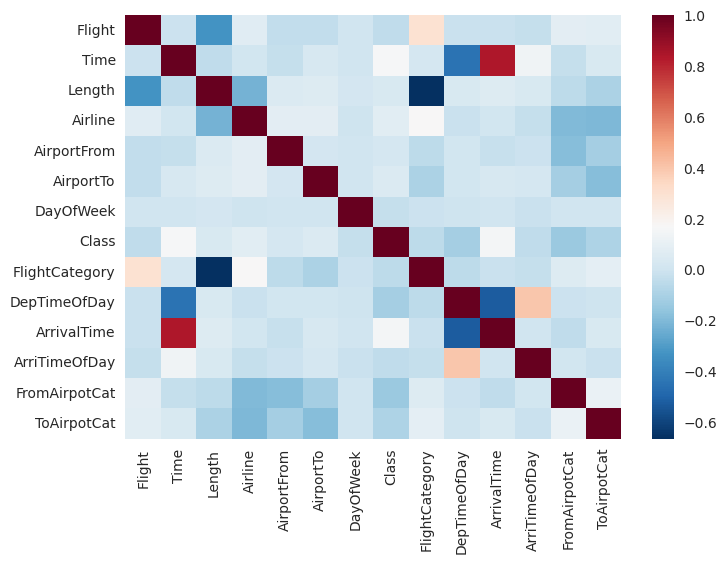

In [22]:
corr_matrix = df.corr(method='spearman')  # 'pearson' is default

sns.heatmap(corr_matrix, cmap='RdBu_r')
plt.show()

In [24]:
df_1 = pd.get_dummies(df)
df_1.columns
# corr_matrix = df_1.corr(method='spearman')  # 'pearson' is default

# sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
# plt.show()

Index(['Flight', 'Time', 'Length', 'Airline', 'AirportFrom', 'AirportTo',
       'DayOfWeek', 'Class', 'FlightCategory', 'DepTimeOfDay', 'ArrivalTime',
       'ArriTimeOfDay', 'FromAirpotCat', 'ToAirpotCat'],
      dtype='object')

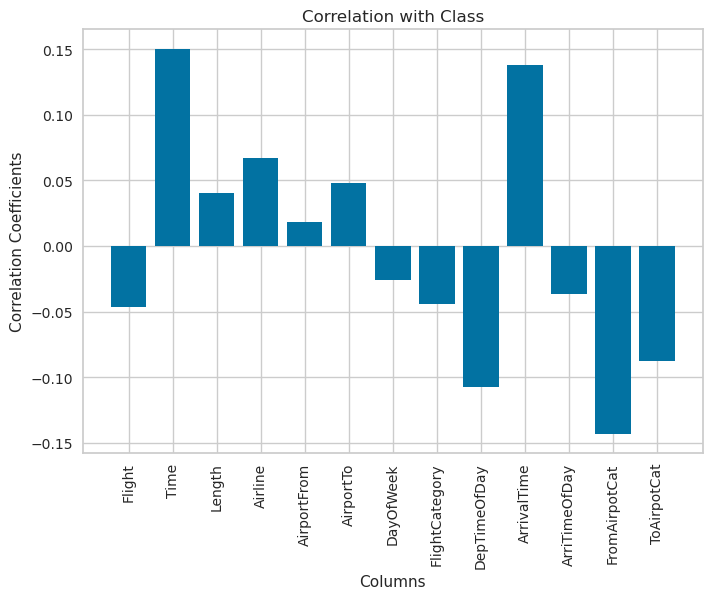

In [25]:
corr = df_1.drop('Class', axis=1).corrwith(df_1['Class'], method='pearson')

plt.bar(corr.index, corr.values)


plt.title('Correlation with Class')
plt.xlabel('Columns')
plt.ylabel('Correlation Coefficients')
plt.xticks(rotation=90)

plt.show()

In [ ]:
#sns.barplot(df,x='IsLate',y = 'Time' , hue='Class')
# sns.countplot(data= df, x= 'FromAirpotCat', hue='Class')
# plt.clf()
#sns.countplot(data= df, x= 'FlightCategory', hue='Class')

In [26]:
def detect_outliers(data):
    outlier_percents = {}
    for column in data.columns:
        if data[column].dtype != object:
            q1 = np.quantile(data[column], 0.25)
            q3 = np.quantile(data[column], 0.75)
            iqr = q3 - q1
            upper_bound = q3 + (1.5 * iqr)
            lower_bound = q1 - (1.5 * iqr)
            outliers = data[(data[column] > upper_bound) | (data[column] < lower_bound)][column]
            outlier_percentage = len(outliers) / len(data[column]) * 100
            outlier_percents[column] = outlier_percentage
            outlier_dataframe = pd.DataFrame(data = outlier_percents.values() ,index=outlier_percents.keys() ,columns=['Outlier_percentage'])
    
    return outlier_dataframe.sort_values(by = 'Outlier_percentage', ascending = False)

detect_outliers(df)


,Outlier_percentage
FlightCategory,17.899745
Length,4.755442
Flight,0.000000
Time,0.000000
Airline,0.000000
AirportFrom,0.000000
AirportTo,0.000000
DayOfWeek,0.000000
Class,0.000000
DepTimeOfDay,0.000000


In [ ]:
# remove anomalies from dataframe
df_3 = df.loc[anomaly_preds == 1, :]
df_3.describe()

# PyCaret Model

In [30]:
X = df.drop('Class', axis = 1)
y = df['Class']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


s = setup(data=df, target='Class', session_id=123, normalize=True)

,Description,Value
0,Session id,123
1,Target,Class
2,Target type,Binary
3,Original data shape,"(539382, 14)"
4,Transformed data shape,"(539382, 14)"
5,Transformed train set shape,"(377567, 14)"
6,Transformed test set shape,"(161815, 14)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


In [ ]:
compare_models()

In [18]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.6664,0.7178,0.5035,0.6661,0.5735,0.3081,0.3163,98.4440
xgboost,Extreme Gradient Boosting,0.6655,0.7162,0.5020,0.6650,0.5721,0.3062,0.3144,33.3780
lightgbm,Light Gradient Boosting Machine,0.6585,0.7082,0.4641,0.6678,0.5477,0.2873,0.2996,5.0280
gbc,Gradient Boosting Classifier,0.6495,0.6941,0.4233,0.6683,0.5183,0.2640,0.2811,36.8500
ada,Ada Boost Classifier,0.6413,0.6842,0.4650,0.6324,0.5359,0.2545,0.2625,11.0790
knn,K Neighbors Classifier,0.6229,0.6516,0.5359,0.5835,0.5587,0.2305,0.2312,11.5790
rf,Random Forest Classifier,0.6172,0.6588,0.5526,0.5730,0.5626,0.2226,0.2227,59.0160
et,Extra Trees Classifier,0.6143,0.6162,0.5051,0.5766,0.5385,0.2097,0.2111,56.7390
ridge,Ridge Classifier,0.6069,0.0000,0.4549,0.5741,0.5076,0.1877,0.1912,0.4890
lda,Linear Discriminant Analysis,0.6069,0.6391,0.4563,0.5740,0.5084,0.1880,0.1915,0.9390


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [31]:
best = compare_models()
evaluate_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.6664,0.7178,0.5035,0.6661,0.5735,0.3081,0.3163,95.6530
xgboost,Extreme Gradient Boosting,0.6655,0.7162,0.5020,0.6650,0.5721,0.3062,0.3144,32.6980
lightgbm,Light Gradient Boosting Machine,0.6585,0.7082,0.4641,0.6678,0.5477,0.2873,0.2996,4.7390
gbc,Gradient Boosting Classifier,0.6495,0.6941,0.4233,0.6683,0.5183,0.2640,0.2811,36.7430
ada,Ada Boost Classifier,0.6413,0.6842,0.4650,0.6324,0.5359,0.2545,0.2625,11.2900
knn,K Neighbors Classifier,0.6229,0.6516,0.5359,0.5835,0.5587,0.2305,0.2312,11.5570
rf,Random Forest Classifier,0.6172,0.6588,0.5526,0.5730,0.5626,0.2226,0.2227,58.6870
et,Extra Trees Classifier,0.6143,0.6162,0.5051,0.5766,0.5385,0.2097,0.2111,57.3710
ridge,Ridge Classifier,0.6069,0.0000,0.4549,0.5741,0.5076,0.1877,0.1912,0.5320
lda,Linear Discriminant Analysis,0.6069,0.6391,0.4563,0.5740,0.5084,0.1880,0.1915,0.8930


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
cb = create_model("catboost")

In [7]:
from catboost import CatBoostClassifier

# create CatBoostClassifier object
model = CatBoostClassifier()

In [32]:
model.fit(X_train, y_train,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.137427
0:	learn: 0.6782551	total: 96.3ms	remaining: 1m 36s
1:	learn: 0.6670468	total: 190ms	remaining: 1m 34s
2:	learn: 0.6590627	total: 278ms	remaining: 1m 32s
3:	learn: 0.6526063	total: 374ms	remaining: 1m 33s
4:	learn: 0.6479553	total: 473ms	remaining: 1m 34s
5:	learn: 0.6443972	total: 563ms	remaining: 1m 33s
6:	learn: 0.6415867	total: 654ms	remaining: 1m 32s
7:	learn: 0.6391743	total: 744ms	remaining: 1m 32s
8:	learn: 0.6375440	total: 837ms	remaining: 1m 32s
9:	learn: 0.6360737	total: 930ms	remaining: 1m 32s
10:	learn: 0.6350079	total: 1.03s	remaining: 1m 32s
11:	learn: 0.6340448	total: 1.11s	remaining: 1m 31s
12:	learn: 0.6331236	total: 1.2s	remaining: 1m 31s
13:	learn: 0.6323557	total: 1.29s	remaining: 1m 31s
14:	learn: 0.6316638	total: 1.38s	remaining: 1m 30s
15:	learn: 0.6310221	total: 1.48s	remaining: 1m 31s
16:	learn: 0.6305332	total: 1.57s	remaining: 1m 30s
17:	learn: 0.6299829	total: 1.65s	remaining: 1m 30s
18:	learn: 0.6296205	total: 1.74s	remaining:

In [ ]:
pip install ipywidgets

In [3]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
import catboost
w = catboost.MetricVisualizer('/crossentropy/')
w.start()

In [35]:
y_pred = model.predict(X_test)

In [36]:
y_pred

array([0, 1, 0, ..., 1, 1, 0])

In [37]:
from sklearn.metrics import accuracy_score

# calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.6670745385948812
